In [1]:
import io
import os
import sys
module_path = os.path.abspath(os.path.join(".."))
if module_path not in sys.path:
    sys.path.append(module_path)
import ipywidgets as widgets
import requests
import pandas as pd

from tqdm import trange, tqdm
from PIL import Image
from owslib.wms import WebMapService
from owslib.wfs import WebFeatureService
from owslib.wmts import WebMapTileService, TileMatrixSet, TileMatrix
from pyproj import CRS, Transformer
from owslib.etree import etree
from owslib.util import testXMLValue
from logzero import logger

# Calcul de la position d'une tuile WMTS


Ressources : 

- [Carte interactive](https://www.geoportail.gouv.fr/carte)
- [Documentation WMTS](https://geoservices.ign.fr/documentation/services/api-et-services-ogc/images-tuilees-wmts-ogc)

# Récupération de la table d'échelles

In [2]:
#WMTS_SERVICE_URL = "https://wxs.ign.fr/satellite/geoportail/wmts"
WMTS_SERVICE_URL = "https://wxs.ign.fr/ortho/geoportail/wmts?SERVICE=WMTS"
CORRESPONDANCE_TABLE_URL = "https://developers.arcgis.com/documentation/mapping-apis-and-services/reference/zoom-levels-and-scale/"
DATA_PATH = os.path.join('..', "data")
CORRESPONDANCE_TABLE_PATH = os.path.join(DATA_PATH, 'correspondance_table.csv')
ADRESS_MODE = True

wmts = WebMapTileService(WMTS_SERVICE_URL, version='1.0.0')
PM_MATRIX_SET: TileMatrixSet = wmts.tilematrixsets["PM"]
wmts.identification.title

'Service de visualisation WMTS Geoportail Publics'

In [3]:
def load_available_options(correspondance_table_path, url):
    if os.path.exists(correspondance_table_path):
        logger.info("Existing correspondance table found, loading it now.")
        correspondance_table = pd.read_csv(correspondance_table_path, sep=';')
    else:
        logger.warning("No correspondance table found, building one now from the given url.")
        correspondance_table = pd.read_html(url)[0]
        correspondance_table["Usage suggestion"] = correspondance_table["Usage suggestion"].fillna(method='ffill')
        correspondance_table["New legend"] = correspondance_table["Zoom level"].astype(str) + \
                                            " - " + correspondance_table["Scale"].astype(str) + " - " + correspondance_table["Usage suggestion"]
        correspondance_table = correspondance_table.set_index("Zoom level")
        correspondance_table.to_csv(correspondance_table_path, sep=";")
        
    available_zoom_levels = list(set(correspondance_table.index).intersection(set([int(key) for key in PM_MATRIX_SET.tilematrix.keys()])))
    correspondance_table = correspondance_table.iloc[available_zoom_levels].sort_index()
    available_options = correspondance_table.loc[:, "New legend"].to_list()
    return available_options

def convert_coordinates(longitude: float, latitude: float):
    gps_crs = CRS("EPSG:4326")
    mercator_crs = CRS("EPSG:3857")
    coordinates_transformer = Transformer.from_crs(gps_crs, mercator_crs, always_xy=True)
    x, y = coordinates_transformer.transform(longitude, latitude)
    return x, y

def compute_tile_position(matrix_set: TileMatrixSet, zoom_level: int, longitude: float, latitude: float):
    # TileMatrixSet.tilematrix is a dictionnary containing the matrices !
    matrix_set_dict: dict[str, TileMatrix] = matrix_set.tilematrix
    target_matrix = matrix_set_dict[str(zoom_level)]
    tile_width_meters = target_matrix.scaledenominator * 0.00028 * 256
    print(f"Tile width in meters : {tile_width_meters}")
    x0, y0 = map(lambda x: float(x), target_matrix.topleftcorner)
    x, y = convert_coordinates(longitude=longitude, latitude=latitude)
    print(f"X = {x}, Y = {y}, identifier = {target_matrix.identifier}")
    tile_col, tile_row  = (x - x0) / tile_width_meters, (y0 - y) / tile_width_meters
    tile_col, tile_row = int(round(tile_col, 0)), int(round(tile_row, 0))
    return tile_row, tile_col

def get_concat_image(grid_length, grid_width, tile_row, tile_column, layer, zoom_level):
    total_width = 256 * grid_width
    total_height = 256 * grid_length
    dst = Image.new('RGB', (total_width, total_height))
    for i, row in enumerate(trange(tile_row-1, tile_row+2)):
        for j, col in enumerate(range(tile_column-1, tile_column+2)):
            request = wmts.gettile(layer=layer,
                tilematrixset="PM", 
                tilematrix=zoom_level, 
                row=row,
                column=col)
            temp_img = Image.open(io.BytesIO(request.read()))
            dst.paste(temp_img, (j*256, i*256))
    return dst
    
def identify_coordinates(address):
    """This functions performs an API call with the scrapped address of the restaurant to the OpenStreetMap API.
    A longitude and a latitude are then returned."""
    
    target_url = 'https://nominatim.openstreetmap.org/search?q=' + address + '&format=json'
        
    target_url = target_url.replace(',', '%2C')
    target_url = target_url.replace(' ', '+')

    r = requests.get(target_url)
    found_coordinates = True
    if r.status_code == 200:
        try:
            coordinates = r.json()[0]
            latitude, longitude = coordinates['lat'], coordinates['lon']
            
        except:
            print(f'Address not found for: {target_url}')
            latitude, longitude = None, None
            found_coordinates = False
            
    else:
        print(f'Error {r.status_code} ocurred on the request')
        latitude, longitude, found_coordinates = None, None, False
    return latitude, longitude, found_coordinates 

In [4]:
if ADRESS_MODE:
    adress_widget = widgets.Textarea(
        placeholder = "Test",
        value = "Hello world",
        description='Adress',
    )

else:
    latitude_widget = widgets.BoundedFloatText(
        value=48.858007,
        description='Latitude',
    )
    longitude_widget = widgets.BoundedFloatText(
        value=2.294535,
        description='Longitude',
    )
    
available_options = load_available_options(CORRESPONDANCE_TABLE_PATH, CORRESPONDANCE_TABLE_URL)

zoom_level_widget = widgets.Dropdown(
    options=available_options,
    value=available_options[0],
    description='Zooming level'
)


layer_widget = widgets.Dropdown(
    options=wmts.contents.keys(),
    # value=0,
    description='Layer'
)



[I 221101 09:48:39 2734488934:3] Existing correspondance table found, loading it now.


In [5]:
if ADRESS_MODE:
    adress = input("Enter an adress:")
    

In [6]:
if not ADRESS_MODE:
    display(latitude_widget)
    display(longitude_widget)

display(zoom_level_widget)
display(layer_widget)
display(adress_widget)

Dropdown(description='Zooming level', options=('0 - 591657527.591555 - Global', '1 - 295828763.795777 - Global…

Dropdown(description='Layer', options=('HR.ORTHOIMAGERY.ORTHOPHOTOS', 'ORTHOIMAGERY.ORTHOPHOS.RESTRICTEDAREAS'…

Textarea(value='Hello world', description='Adress', placeholder='Test')

In [16]:
if ADRESS_MODE:
    LATITUDE, LONGITUDE, has_found_adress = identify_coordinates(adress)
else:
    LATITUDE = latitude_widget.value
    LONGITUDE = longitude_widget.value

ZOOM_LEVEL = int(zoom_level_widget.value[:2])
LAYER = layer_widget.value
if has_found_adress:
    print("Adress found !")

Adress found !


# WMTS analysis

In [17]:
matrix_set = wmts.tilematrixsets["PM"]
tile_row, tile_column = compute_tile_position(matrix_set, ZOOM_LEVEL, LONGITUDE, LATITUDE)
print(f"Tile row nb: {tile_row}, Tile column nb:{tile_column}")

Tile width in meters : 78271.51696402043
X = 257554.20629046846, Y = 6253688.151068818, identifier = 9
Tile row nb: 176, Tile column nb:259


100%|██████████| 3/3 [00:01<00:00,  1.75it/s]


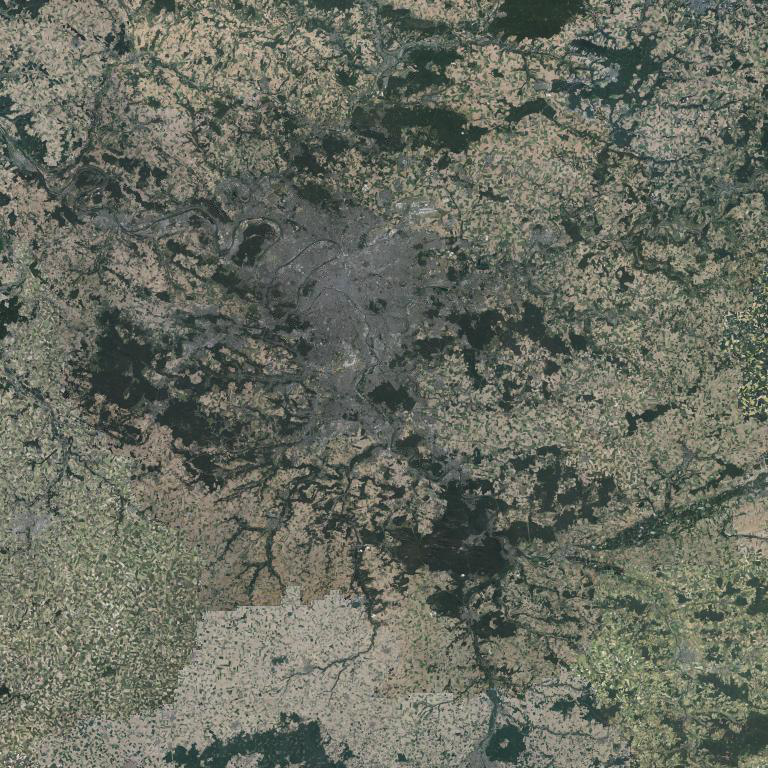

In [18]:
dst = get_concat_image(3, 3, tile_row, tile_column, LAYER, ZOOM_LEVEL)
display(dst)

# Legacy code

In [ ]:
# Version XML

# Extracts capabilities
# capabilities = etree.fromstring(wmts.getServiceXML())
# Extracts contents
# caps = capabilities.find(_CONTENTS_TAG)
# tl = testXMLValue(elem.find(_TOP_LEFT_CORNER_TAG))
# print(tl)

# Extracts Tile Matrix Sets
# tilematrixsets = {}
# for elem in caps.findall(_TILE_MATRIX_SET_TAG):
#     print(testXMLValue(elem.find(_IDENTIFIER_TAG)).strip())
    # print(elem.find(_TOP_LEFT_CORNER_TAG))
    # tms = TileMatrixSet(elem)
    # if tms.identifier:
    #     if tms.identifier in tilematrixsets:
    #         raise KeyError('TileMatrixSet with identifier "%s" '
    #                         'already exists' % tms.identifier)
    #     tilematrixsets[tms.identifier] = tms

# tilematrixsets

In [ ]:
# HARDCODED_METERS_PER_PIXEL = 0.5971642835
# pm_matrix_set = [matrix_set for matrix_set in caps.findall(_TILE_MATRIX_SET_TAG) if matrix_set.find(_IDENTIFIER_TAG).text.strip() == "PM"][0]
# pm_matrix_set
# scale_range = range(SCALE-5, SCALE+6)
# target_matrix = [matrix for matrix in pm_matrix_set.findall(_TILE_MATRIX_TAG) if int(float(matrix.find(_SCALE_DENOMINATOR_TAG).text)) in scale_range][0]
# target_top_corner = target_matrix.find(_TOP_LEFT_CORNER_TAG).text.split()
# target_identifier = int(target_matrix.find(_IDENTIFIER_TAG).text)
# target_height = int(target_matrix.find(_TILE_HEIGHT_TAG).text)
# target_width = int(target_matrix.find(_TILE_WIDTH_TAG).text)
# tile_meter_length = target_height * HARDCODED_METERS_PER_PIXEL
# x0, y0 = map(lambda x: float(x), target_top_corner)
# x0, y0
# tile_meter_length

# def get_concat_h(im1, im2):
#     dst = Image.new('RGB', (im1.width + im2.width, im1.height))
#     dst.paste(im1, (0, 0))
#     dst.paste(im2, (im1.width, 0))
#     return dst

# def get_concat_v(im1, im2):
#     dst = Image.new('RGB', (im1.width, im1.height + im2.height))
#     dst.paste(im1, (0, 0))
#     dst.paste(im2, (0, im1.height))
#     return dst

# def get_concat_image(image_grid):
#     # total_width = sum([img.width for img in image_grid[0]])
#     # total_height = sum([img.height for img in image_grid])
#     total_width = 256 * len(image_grid[0]) 
#     total_height = 256 * len(image_grid)
#     dst = Image.new('RGB', (total_width, total_height))
#     for i in range(len(image_grid[0])):
#         for j in range(len(image_grid)):
#             dst.paste(image_grid[i][j], (j*256, i*256))
#     return dst

# image_grid = [[] for i in range(0, 3)]
# for i, row in enumerate(trange(tile_row-1, tile_row+2)):
#     for j, col in enumerate(range(tile_column-1, tile_column+2)):
#         request = wmts.gettile(layer=LAYER,
#                 tilematrixset="PM", 
#                 tilematrix=ZOOM_LEVEL, 
#                 row=row,
#                 column=col)
#         image_grid[i].append(Image.open(io.BytesIO(request.read())))

In [ ]:
# zoom_level = 14
# C = 2*pi * 6_378_137.000
# nb_tiles = 2**(2*zoom_level)
# nb_tiles
# tile_width = 360/(2**zoom_level)
# tile_width * 113.32 * 1000
# tile_width_meter = (C * (cos(radians(LATITUDE))) ) / (2**(zoom_level+8))
# tile_width_meter
# zoom_level = identifier
# # zoom_level = int(identifier)
# horizontal_tile_distance = (C * cos(radians(LATITUDE)) ) / (2 ** zoom_level)
# ((2 * pi * 6371 * 1000 * tile_width)/360)/256

# WMS analysis

In [ ]:
wms = WebMapService(WMS_SERVICE_URL, version='1.3.0')
wms.identification.title

In [ ]:
print(wms.getOperationByName('GetMap').methods)
print(wms.getOperationByName('GetMap').formatOptions)

In [ ]:
list(wms.contents)

In [ ]:
layer = wms['ORTHOIMAGERY.ORTHO-SAT.SPOT.2021']
print(layer.crsOptions)
print(layer.styles)
print(layer.boundingBox[0:4])


In [ ]:
img = wms.getmap(layers=['ORTHOIMAGERY.ORTHO-SAT.SPOT.2021'],
                styles=['normal'],
                bbox = layer.boundingBox[0:4],
                # Left, bottom, right, top
                # bbox =(-220163.801503544, 2050671.178294608, 195507.700339527, 1641180.194057136),
                # srs='EPSG:2154',
                # srs = layer.boundingBox[4],
                srs = "EPSG:3857",
                # bbox=(-112, 36, -106, 41),
                # bbox = (-20, 20, -20, 20),
                size=(2000, 2000),
                format='image/png',
                transparent=True
)

Image(img.read())

In [ ]:
img = wms.getmap(layers=['ORTHOIMAGERY.ORTHO-SAT.PLEIADES.2020'],
                # styles=['normal'],
                bbox = layer.boundingBox[0:4],
                # Left, bottom, right, top
                # bbox =(-220163.801503544, 2050671.178294608, 195507.700339527, 1641180.194057136),
                # srs='EPSG:2154',
                srs = layer.boundingBox[4],
                # srs = "ESPG:4258",
                # bbox=(-112, 36, -106, 41),
                # bbox = (-20, 20, -20, 20),
                size=(2000, 2000),
                format='image/png',
                transparent=True
)

Image(img.read())

In [ ]:
with open('test_img.png', 'wb') as outfile:
    outfile.write(img.read())